In [1]:
include("figures-preamble.jl")
using Poltergeist, ApproxFun

## Lanford map

In [2]:
a = (5 - sqrt(17))/2; 
f1(x) = 5x/2 - x^2/2; f2(x) = f1(x)-1
f = MarkovMap([f1,f2],[0..a,a..1],0..1);
L = Transfer(f); # transfer operator represented as an ApproxFun Operator object
rho = acim(L); # Fun object; obtained via solution operator equation
lyap = sum(Fun(x->log(abs(f'(x))),0..1) * rho) # quadrature using ApproxFun

0.6576617800065976

In [3]:
bvar = Poltergeist.birkhoffvar(L,Fun(x->x^2,0..1))

0.36010948619916205

In [4]:
s = sum(rho*Fun(identity,0..1))

0.548591793174868

In [12]:
using JLD
N = 2048;
prec = 8round(Int,(N+512)*0.2/8)
setprecision(prec)
 run(`unzip -o /Users/johnwormell/Documents/Spectral/Lanford-S$N.zip tmp/tmppdy794/Lanford-S2048.jld`)

ld = load("tmp/tmppdy794/Lanford-S2048.jld");
run(`rm tmp/tmppdy794/Lanford-S2048.jld`);

Archive:  /Users/johnwormell/Documents/Spectral/Lanford-S2048.zip
  inflating: tmp/tmppdy794/Lanford-S2048.jld  


In [13]:
setprecision(prec)
rho_hi = ld["hi"][:,1]; rho_lo = ld["lo"][:,1];
rho_coefs = (rho_hi + rho_lo)/2
rhodiff_coefs = convert(Array{Float64},rho_coefs-pad(rho.coefficients,N))
rhodiff = Fun(Chebyshev(0..1),rhodiff_coefs)
lan_BVerr = sum(abs(rhodiff')); println("BV error = $lan_BVerr")
lInferr = maxabs(rhodiff_coefs); println("maximum coefficient error = $lInferr")

BV error = 2.8797280635879655e-13
maximum coefficient error = 7.899547595972759e-15


In [14]:
lyap_exact = big"6.5766178000659767754158241382383206574324106958001220195395280269163266611155402375955645975291517482964215633179802630148859489e-1"
println(convert(Float64,abs(lyap_exact - lyap)))

bvar_exact = big"0.3601094861991606728988241868285767492416699977972288643589778658381744031036174779814027832110836467690394108480319999606647"
println(convert(Float64,abs(bvar_exact - bvar)))

9.258386529631961e-17
1.381477364093174e-15


### Plotting convergence

In [15]:
Si = SolutionInv(L); u = Poltergeist.uniform(rangespace(L));
NN = 40
lan_BVerrs = Array(Float64,40)
for n = 1:40
    rn = (\)(Si,u,maxlength=n)
#     rn = Fun(Chebyshev(0..1),Si[1:n,1:n]\pad(u.coefficients,n))
    rndiff_coefs = convert(Array{Float64},rho_coefs-pad(rn.coefficients,N))
    rndiff = Fun(Chebyshev(0..1),rndiff_coefs)
    lan_BVerrs[n] = sum(abs(rndiff'))+sum(abs(rndiff))
end

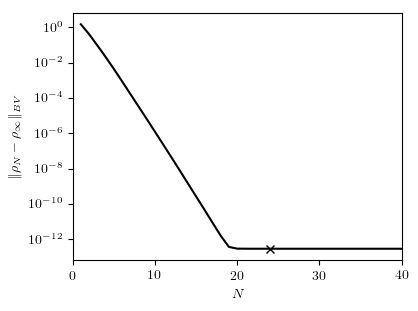

In [16]:
figure(figsize=(5*0.75/0.7*0.8,3.75*0.75/0.7*0.8))
semilogy(1:40,lan_BVerrs,"k")
plot([24],[lan_BVerr],"kx")
xlim(0,40)
xlabel("\$N\$"); ylabel("\$\\|\\rho\_N - \\rho\_\\infty\\|\_\{BV\}\$")

tight_layout()
savefig("../figures/adaptive-1.eps")

## Circle Map

In [17]:
function Ws4(x::Float64)
    y = zero(x)
    pow = -oftype(x,33)/8
    sx62 = 2sin(x/6)^2
    twopow = 2^pow
    for ki = (20:-1:0)
        y += cos(2^ki*sx62)*twopow^ki
    end
    y
end
Ws4f(x) = x/3+Ws4(x)

function Ws4d_times3(x::Float64)
    y = zero(x)
    pow = -oftype(x,33)/8
    sx3 = sin(x/3)
    sx62 = 2sin(x/6)^2
    twopow1 = 2^(pow+1)
    for ki = (20:-1:0)
        y -= sx3*sin(2^ki*sx62)*twopow1^ki
    end
    y
end
Ws4df{T}(x::T) = (1+Ws4d_times3(x))/3
g = CircleMap(Ws4f,0..2pi,0..2pi,dir=Reverse,diff=Ws4df)
Lg = Transfer(g); Si = SolutionInv(Lg)
@time rhog = acim(Si)

390.509334 seconds (2.66 G allocations: 82.639 GB, 7.99% gc time)


Fun(Fourier(【0.0,6.283185307179586❫),[0.159155,0.0184858,-0.00391516,-0.000504504,6.34477e-5,-6.69747e-5,1.36742e-6,3.96156e-6,-1.67745e-6,-3.88312e-6  …  -1.70984e-14,-1.40342e-15,1.08018e-14,-1.64542e-15,1.20333e-14,6.89211e-16,6.31882e-20,1.17312e-15,-2.98272e-19,3.91623e-20])

In [18]:
ncoefficients(rhog)

2747

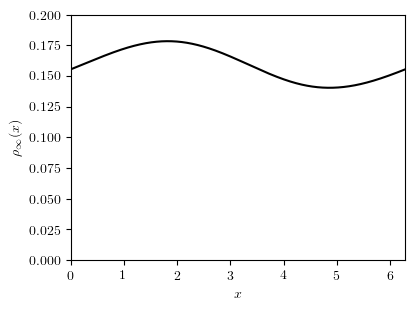

In [19]:
## TODO : RUN IN BIGFLOAT
figure(figsize=(5*0.75/0.7*0.8,3.75*0.75/0.7*0.8))
plot(points(rhog),values(rhog),"k")
xlim(0,2pi)
ylim(0,0.2)
xlabel("\$x\$"); ylabel("\$\\rho\_\\infty(x)\$")
tight_layout()
savefig("../figures/adaptive-2.eps")


In [20]:
# Loading bigfloat mtrix
Lg_bf = load("/Users/johnwormell/Documents/Spectral/Circle_data.jld")["Lg"];

In [21]:
N_bf = 6144
K = I - Lg_bf[1:N_bf,1:N_bf];
K[1,:] += DefiniteIntegral(Fourier(0..2pi))[1:N_bf]/2pi
rho_g_bf = K\[1/2pi;zeros(N_bf-1)];

In [22]:
u = Poltergeist.uniform(rangespace(Lg));
NN = 8000
Nplt = 100
BVerrs = Array(Float64,Nplt)
# H1errs = Array(Float64,Nplt)
NBVsum = nextpow2(3NN)
for (ind,n) = enumerate(round(Int,logspace(log10(4),log10(NN),Nplt)))
#     rn = (\)(Si,u,maxlength=n)
    rn = Fun(Fourier(0..2pi),Si[1:n,1:n]\pad(u.coefficients,n))
    rndiff_coefs = convert(Array{Float64},rho_g_bf-pad(rn.coefficients,N_bf))
    rndiff = Fun(Fourier(0..2pi),rndiff_coefs)
    BVerrs[ind] = norm(values(pad(rndiff,NBVsum)),1)/NBVsum*2pi+norm(values(pad(rndiff',NBVsum)),1)/NBVsum*2pi
#     H1errs[ind] = norm(rndiff',2)+norm(rndiff,2)
end

In [23]:
rhogdiff_coefs = convert(Array{Float64},rho_g_bf-pad(rhog.coefficients,N_bf))
rhogdiff = Fun(Fourier(0..2pi),rhogdiff_coefs)
BVerr = norm(values(pad(rhogdiff,64NBVsum)),1)/64NBVsum*2pi+norm(values(pad(rhogdiff',64NBVsum)),1)/64NBVsum*2pi
# H1err = norm(rhogdiff',2)+norm(rhogdiff,2)

4.777346437265215e-10

In [27]:
BVerr

4.777346437265215e-10

In [28]:
H1errs

100-element Array{Float64,1}:
 0.000663584
 0.000663584
 0.000527515
 0.000527515
 0.000527515
 8.26112e-5 
 8.26112e-5 
 8.81221e-5 
 8.81221e-5 
 7.8313e-5  
 7.67363e-5 
 7.67363e-5 
 6.32098e-5 
 ⋮          
 2.35351e-10
 2.35351e-10
 2.35351e-10
 2.35351e-10
 2.35351e-10
 2.35351e-10
 2.35351e-10
 2.35351e-10
 2.35351e-10
 2.35351e-10
 2.35351e-10
 2.35351e-10

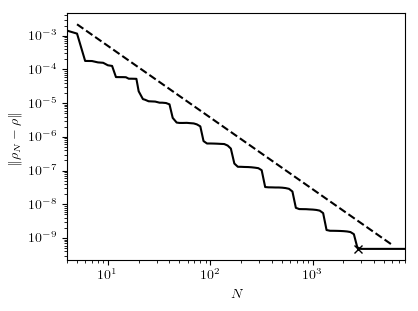

In [24]:
pltN = round(Int,logspace(log10(4),log10(NN),Nplt))
figure(figsize=(5*0.75/0.7*0.8,3.75*0.75/0.7*0.8))
# loglog(pltN,H1errs,"k-.")
# plot([ncoefficients(rhog)],[H1err],"kv")

loglog(pltN,BVerrs,"k")
plot([ncoefficients(rhog)],[BVerr],"kx")


xlim(0,NN)
xlabel("\$N\$"); ylabel("\$\\|\\rho\_N - \\rho\\|\$")

plot(pltN[4:end-4],pltN[4:end-4].^(2-33/8)/ 15,"k--")
tight_layout()
savefig("../figures/adaptive-3.eps")

In [32]:
phi_av

LoadError: UndefVarError: phi_av not defined

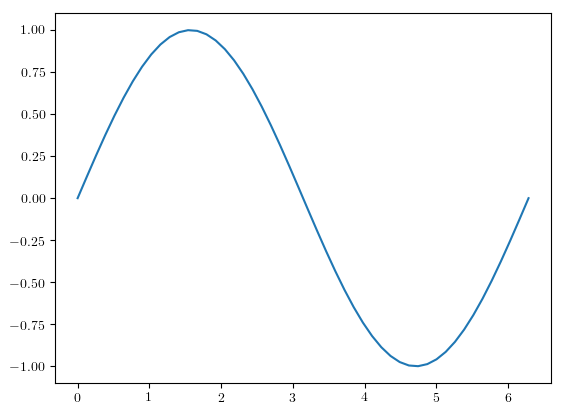

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x326e99ad0>

In [29]:
plot(linspace(0,2pi),Fun(Fourier(),[0.,1.]).(linspace(0,2pi)))

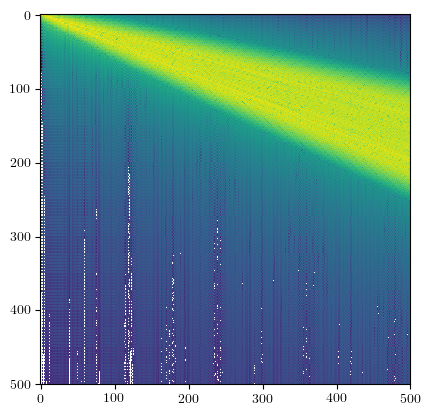

PyObject <matplotlib.image.AxesImage object at 0x32ca9d5d0>

In [208]:
imshow(log(abs(L[1:500,1:500])))

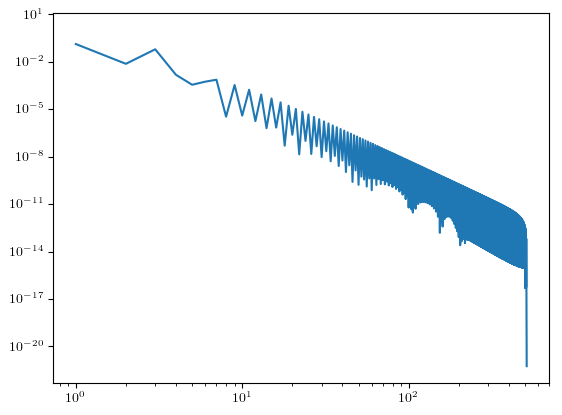

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32db1e910>

In [217]:
loglog(abs(rhog.coefficients))

In [166]:
L.datasize

(1024,664)

In [1]:
methods(wait)

# 18 methods for generic function "wait":
wait(c::Condition) at event.jl:22
wait(async::Base.AsyncCondition) at event.jl:230
wait(t::Timer) at event.jl:318
wait(t::Task) at task.jl:126
wait(fdw::Base.Filesystem.FDWatcher) at poll.jl:318
wait(fdw::Base.Filesystem._FDWatcher; readable, writable) at poll.jl:321
wait(fd::RawFD; readable, writable) at poll.jl:335
wait(pfw::PollingFileWatcher) at poll.jl:355
wait(m::FileMonitor) at poll.jl:362
wait(x::Base.Process) at process.jl:716
wait(x::Base.ProcessChain) at process.jl:717
wait(rv::Base.RemoteValue) at multi.jl:977
wait(r::Future) at multi.jl:1145
wait(state::Base.AsyncCollectorState) at asyncmap.jl:55
wait(socket::ZMQ.Socket) at /Users/johnwormell/.julia/v0.5/ZMQ/src/ZMQ.jl:273
wait() at event.jl:145
wait(c::Channel) at channels.jl:90
wait(r::RemoteChannel, args...) at multi.jl:1146

In [34]:
realpart(Dual(0.,1.))

0.0

In [72]:
using DualNumbers
cotshiftv(x,k) =rem(atan2(-sin(2pi*x),-cos(2pi*x)-k*sin(2pi*x))/2pi+0.5,1)+floor(x)
cotshiftv(x::Dual,k) = Dual(cotshiftv(realpart(x),k),dualpart(atan(-sin(2pi*x)/(-cos(2pi*x)-k*sin(2pi*x)))/2pi+0.5))
dconj_liftv_05(x) = cotshiftv(cotshiftv(x,-0.05)/2,0.05)
dconj = CircleMap(dconj_liftv_05,0..1,0..1,dir="rev")
L = Transfer(dconj)
acim(L)

Fun(Fourier(【0.0,1.0❫),[1.0,-9.86598e-16,-1.57101e-15,0.0499688,0.00124922,-2.93209e-16,1.69465e-16,6.24219e-5,-0.00124766,-4.71766e-16  …  2.98238e-13,2.52284e-14,1.72063e-15,-2.55116e-16,1.69392e-15,1.99991e-16,8.14991e-18,-4.6666e-17,-1.82409e-17,-8.99474e-19])

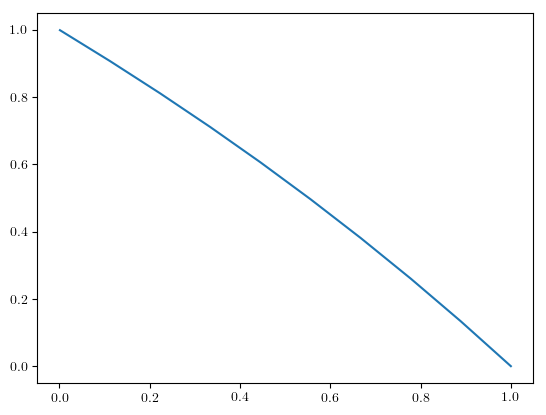

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31faf1750>

In [81]:
zplt = linspace(0.001,1,10)
plot(zplt,[det(I-z*Lg) for z = zplt])

In [46]:
Nv = round(Int,logspace(1,2.4,10))
Ev = Array(Float64,10)
for i = eachindex(Nv)
    Ev[i] = sort(abs(eigvals(Lg[1:Nv[i],1:Nv[i]])))[end-1]
end

In [51]:
eigvals(Lg_bf[1:6000,1:6000],3)

LoadError: InterruptException:

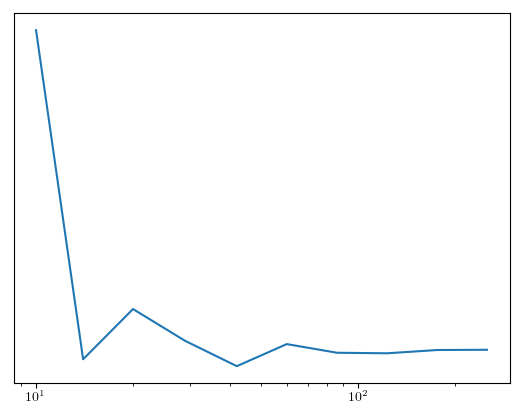

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3321acf10>

In [52]:
loglog(Nv,Ev)

In [ ]:
eigvals(Lg[1:4000,1:4000])[1]

In [42]:
eigmax = abs([reim(eigvals(Lg[1:4000,1:4000])[1])...])
ed = zeros(20)
for (n,N) = enumerate([round(Int,x) for x in logspace(1,3,20)])
    ed[n] = norm(abs([reim(eigvals(Lg[1:N,1:N])[1])...])-eigmax)
end

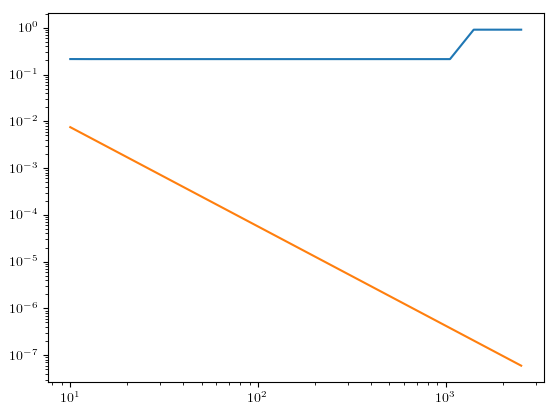

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x324dbfbd0>

In [39]:
lgsp = logspace(1,3.4,20)
loglog([round(Int,x) for x in lgsp],ed)
plot(lgsp,lgsp.^(2-33/8))